# Twitter Sentiment Analysis using ULMFiT



## Problem Description

A sentiment analysis job has to be done regarding the problems of each major U.S. airline and contributors. We have to first classify positive, negative and neutral tweets, and then categorize the negative tweets according to the reasons provided i.e. "late flight" or "rude service". This problem along with the tataset is available on Kaggle: https://www.kaggle.com/crowdflower/twitter-airline-sentiment

We have to apply a  supervised or semi-supervised ULMFiT model to the Twitter US Airlines Sentiment. We will follow the ULMFiT approach of Howard, and Ruder presented in the paper: https://arxiv.org/pdf/1801.06146.pdf. ULMFit stands for Universal Language Model Fine-tuning; it is an efficient Transfer Learning approach that can be extended to any NLP function and implements language model fine-tuning techniques.

### Importing the libraries

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from fastai.metrics import accuracy
from fastai.text import *
from fastai import *

We will check the version of Tensorflow

In [ ]:
tf.__version__

'2.3.0'

## Part 1 - Data Preprocessing

### Importing the dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
!cp -r /content/drive/"My Drive"/"ML Datasets"/Tweets.csv /content

In [ ]:
dataset = pd.read_csv('Tweets.csv')
dataset.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


The first step will be to determine the shape or structure of the data frame and then check the number of null values in each column.


In [ ]:
print('Shape: ', dataset.shape)

Shape:  (14640, 15)


Next, we will identify the different datatypes present in our dataset

In [ ]:
dataset.dtypes

tweet_id                          int64
airline_sentiment                object
airline_sentiment_confidence    float64
negativereason                   object
negativereason_confidence       float64
airline                          object
airline_sentiment_gold           object
name                             object
negativereason_gold              object
retweet_count                     int64
text                             object
tweet_coord                      object
tweet_created                    object
tweet_location                   object
user_timezone                    object
dtype: object

### Handling the missing values

We will first identify how many missing values are present in the dataset. In this way, we can understand the redundant or unnecessary columns in the data set, depending on which column has the maximum number of null values.

In [ ]:
print("The number of nulls in each column are \n", dataset.isna().sum())

The number of nulls in each column are 
 tweet_id                            0
airline_sentiment                   0
airline_sentiment_confidence        0
negativereason                   5462
negativereason_confidence        4118
airline                             0
airline_sentiment_gold          14600
name                                0
negativereason_gold             14608
retweet_count                       0
text                                0
tweet_coord                     13621
tweet_created                       0
tweet_location                   4733
user_timezone                    4820
dtype: int64


In order to get a better estimate and analyze it efficiently, we will calculate the percentage of null values or NA values in each column.

In [ ]:
print("The percentage of null or NA values in dataset")
((dataset.isnull() | dataset.isna()).sum() * 100 / dataset.index.size).round(2)

The percentage of null or NA values in dataset


tweet_id                         0.00
airline_sentiment                0.00
airline_sentiment_confidence     0.00
negativereason                  37.31
negativereason_confidence       28.13
airline                          0.00
airline_sentiment_gold          99.73
name                             0.00
negativereason_gold             99.78
retweet_count                    0.00
text                             0.00
tweet_coord                     93.04
tweet_created                    0.00
tweet_location                  32.33
user_timezone                   32.92
dtype: float64

So now it is evident that 90% of data of the columns tweet_coord , airline_sentiment_gold, negativereason_gold is missing. Hence, it would be better to delete these columns because they will not provide any useful information on our model.

In [ ]:
dataset.drop(["tweet_coord", "airline_sentiment_gold", "negativereason_gold"],axis=1, inplace = True)
dataset.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,name,retweet_count,text,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,cairdin,0,@VirginAmerica What @dhepburn said.,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,jnardino,0,@VirginAmerica plus you've added commercials t...,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,yvonnalynn,0,@VirginAmerica I didn't today... Must mean I n...,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,jnardino,0,@VirginAmerica it's really aggressive to blast...,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,jnardino,0,@VirginAmerica and it's a really big bad thing...,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


### Data Visualization

First, we will visualize the distribution of the primary dependent variable, which is the airline sentiment, along with its tweet-length and breakdown across airlines.

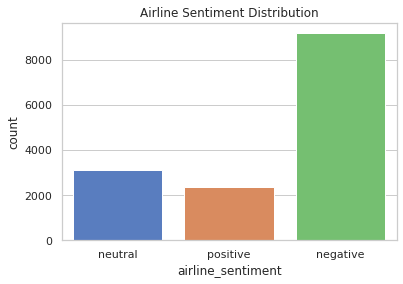

In [ ]:
sns.set(style="whitegrid")
sns.countplot(x=dataset["airline_sentiment"], palette="muted")
plt.title("Airline Sentiment Distribution")
plt.show()

As we can see, the majority of the comments are negative. Which could mean that people are generally dissatisfied with the service provided by the airline companies.

Now we will analyze the distribution of different type of airlines.

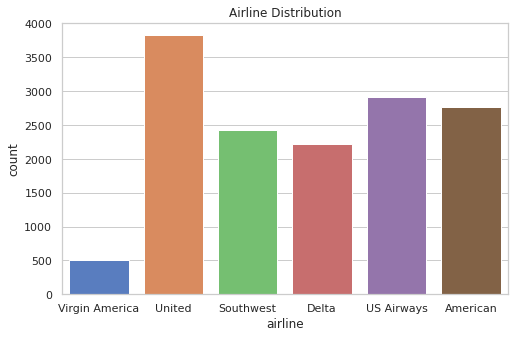

In [ ]:
sns.set(style="whitegrid")
plt.figure(figsize=(8,5))
sns.countplot(x=dataset["airline"], palette="muted")
plt.title("Airline Distribution")
plt.show()

From the above bar graph, it is evident that United Airlines is widely recognized on Twitter. Of course, we do not know if that popularity is positive or negative. Apart from that, the fact that there are very few tweets in Virgin America also gives the impression that perhaps their standard is neither good nor bad.

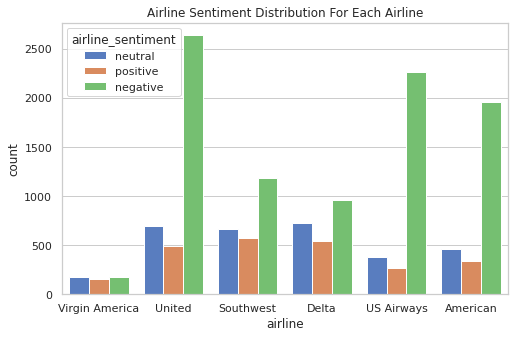

In [ ]:
sns.set(style="whitegrid")
plt.figure(figsize=(8,5))
sns.countplot(x=dataset["airline"], hue=dataset["airline_sentiment"], palette="muted")
plt.title("Airline Sentiment Distribution For Each Airline")
plt.show()

As we can see from the above plot, the airline's sentiments vary significantly depending on the airline. The most positive is Virgin America, while the most negative is United considering the overall sentiment.

Now we will define a new parameter 'tweet_len' which will tell us the length of the tweet present in the 'text' column of out dataset

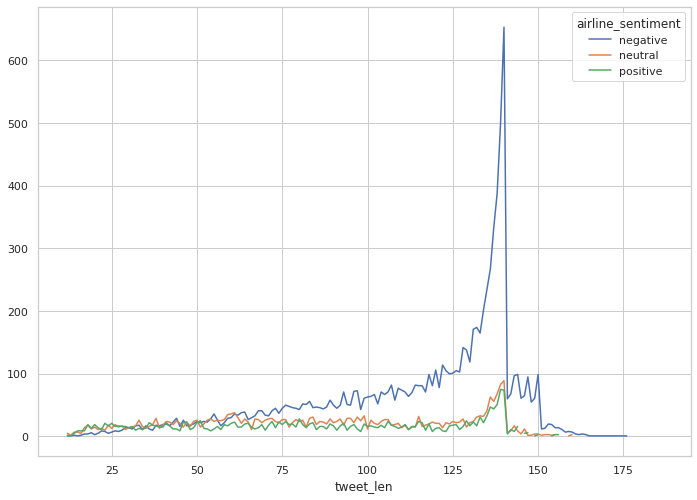

In [ ]:
dataset['tweet_len'] = dataset['text'].apply(len)
df= dataset.groupby(['tweet_len', 'airline_sentiment']).size().unstack().plot(kind='line', stacked=False)

There is not much connection between the amount of positive/neutral tweets and the tweet's duration. However, in the case of negative tweets, the distribution is strongly biased towards longer or longer tweets. This is plausible because angrier the person who tweets, the more he/she has to say.

Now we will analyze the count of different types of Negative Reasons due to which the customers gave a negative tweet.

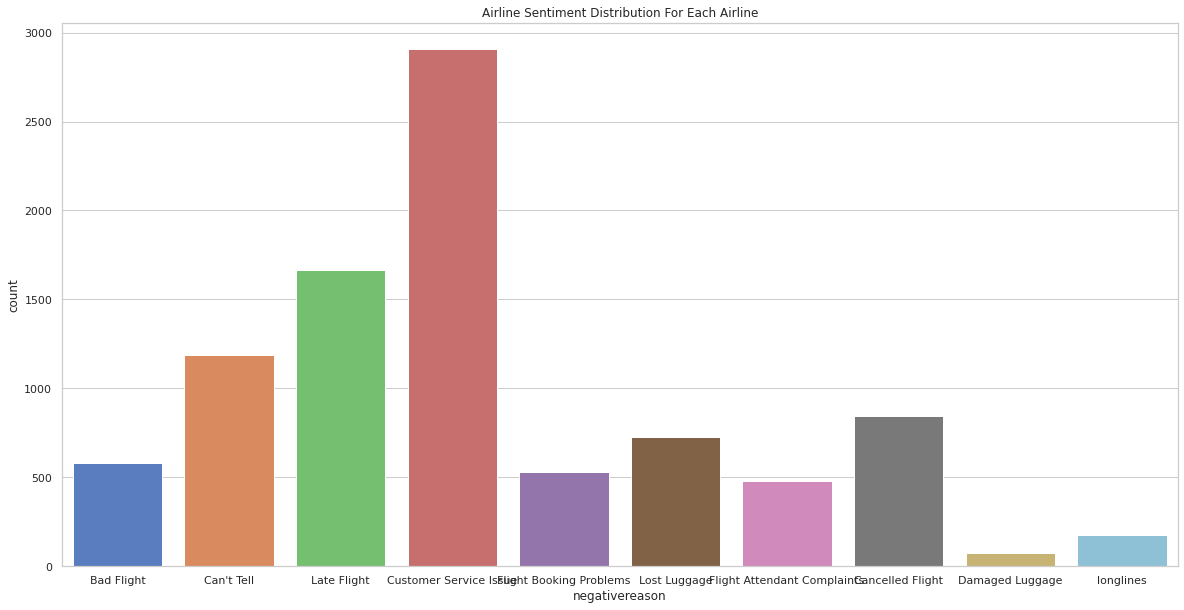

In [ ]:
sns.set(style="whitegrid")
plt.figure(figsize=(20,10))
sns.countplot(x=dataset["negativereason"], palette="muted")
plt.title("Airline Sentiment Distribution For Each Airline")
plt.show()

As it is evident from the bar graph above, a very massive number of people have given reason for their negative tweet  as bad customer service.

### Text Preprocessing

In this section we will process the column named 'Text' which contains the raw text of the tweets posted by customers.

We will basically peform the text preprocessing by using the well known nltk library.
In order to do this we will import the necessary libraries into out notebook.

In [ ]:
import nltk
import re
import sklearn

We will create a new data frame containing just two column that is Airline_sentiment and text.

In [ ]:
tweet_senti = dataset[['airline_sentiment','text']]
tweet_senti

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials t...
2,neutral,@VirginAmerica I didn't today... Must mean I n...
3,negative,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...
...,...,...
14635,positive,@AmericanAir thank you we got on a different f...
14636,negative,@AmericanAir leaving over 20 minutes Late Flig...
14637,neutral,@AmericanAir Please bring American Airlines to...
14638,negative,"@AmericanAir you have my money, you change my ..."


We need to clean the column text.Text cleaning can be done by:
1. Converting all the characters in Lowercase.
2. Removing characters apart from A-Z and a-z.
3. Removing the hashtags #.
4. Replacing 'https://' kind of url into simple text 'link' 

*The class WordNetLemmatizer() is used for Lemmatization. Lemmatization is a process of reducing inflected words to their respective lemmatized words which can be easily understood by human as well(Meaningful Representation.)*

We have not applied Lemmatization to the data.

In the end, we will create a list 'corpus' where we will store all these tweets.


In [ ]:
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer

wordnet = WordNetLemmatizer()
ps = PorterStemmer()
corpus = []
for i in range(0, len(tweet_senti)):
    sntm= re.sub('[^a-zA-Z]', ' ', tweet_senti['text'][i])
    sntm = sntm.lower()
    sntm = sntm.split()
    sntm = re.sub(r'#([^\s]+)', r'\1', tweet_senti['text'][i])
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+))','link',tweet_senti['text'][i])
    #sntm = [ps.stem(word) for word in sntm if not word in set(stopwords.words('english'))]
    #sntm = ' '.join(sntm)
    corpus.append(sntm)
    

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Now we need to replace this 'text' column from the dataframe tweet_senti with the new values of the list corpus.

In [ ]:
tweet_senti['newtext']= corpus
tweet_senti.drop(["text"],axis=1, inplace = True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
tweet_senti

,airline_sentiment,newtext
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials t...
2,neutral,@VirginAmerica I didn't today... Must mean I n...
3,negative,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...
...,...,...
14635,positive,@AmericanAir thank you we got on a different f...
14636,negative,@AmericanAir leaving over 20 minutes Late Flig...
14637,neutral,@AmericanAir Please bring American Airlines to...
14638,negative,"@AmericanAir you have my money, you change my ..."


### Splitting the dataset into the Training set and Test set

We do not need the rest of the columns in the dataset thus, we will only use the two relevant columns that are 'newtext' and 'airline_sentiment' and make this the new dataframe.

In [ ]:
df = tweet_senti[['newtext','airline_sentiment']]
df

,newtext,airline_sentiment
0,@VirginAmerica What @dhepburn said.,neutral
1,@VirginAmerica plus you've added commercials t...,positive
2,@VirginAmerica I didn't today... Must mean I n...,neutral
3,@VirginAmerica it's really aggressive to blast...,negative
4,@VirginAmerica and it's a really big bad thing...,negative
...,...,...
14635,@AmericanAir thank you we got on a different f...,positive
14636,@AmericanAir leaving over 20 minutes Late Flig...,negative
14637,@AmericanAir Please bring American Airlines to...,neutral
14638,"@AmericanAir you have my money, you change my ...",negative


We will split the generated dataframe into Training set and Testing set, where 80% will be in training set and 20% will be in testing set.

In [ ]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df,test_size=0.1,random_state=10)

Now we will convert the training set and testing set into csv files which will be imported later for building the model.

In [ ]:
df_train.to_csv('tweet_train.csv')
df_test.to_csv('tweet_test.csv')

Now we will create a TextLMDataBunch from the csv file

## Part 2 - Building the ULMFiT Model

Universal Language Model Fine-tuning (ULMFIT) is a transfer learning technique that can assist with different NLP tasks. It's been a state-of-the-art NLP technique for a long time.

### Build the Language Model

We will import fastai library in order to build and train our ULMFiT model

In [ ]:
from fastai.text import *

The fastai library text module contains all the required functions to identify a dataset suitable for the different NLP (Natural Language Processing) tasks and generate models using them quickly.

 We will use class TextDataBunch, which is suitable for training the language model.
Then we will create a 'TextLMDataBunch' from tweet_train.csv.
Then we will specify 'valid=0.1' in order to set 10% of our training data for a validation set.

In [ ]:
tweet = TextLMDataBunch.from_csv(path='',csv_name='tweet_train.csv',valid_pct=0.1)


Let us see how this batch looks. In order to do that we will use function show_batch()

In [ ]:
tweet.show_batch()

idx,text
0,"xxmaj leaving at 6:15 am tomorrow xxbos @usairways now on hold for an hour . xxmaj so frustrating , i suspect you have more operators come in on days like this w / inclement weather ? xxbos @americanair i am , called xxmaj paris office this morning again , still waiting . xxmaj it is in xxmaj miami but apparently tag was "" taken off "" xxbos @united thanks for"
1,start service to xxmaj hawaii from sanfrancisco this year http : / / t.co / xxunk xxunk xxbos “ @southwestair : xxmaj companion xxmaj pass . xxmaj because everyone deserves redcarpet treatment and a +1 ( even if it 's your mom ) . http : / / t.co / xxunk ” xxbos @southwestair way to fuck up and lose xxunk bags . xxmaj my husband has no warm clothes
2,@americanair i dmed you my xxup aa & & phone s & & you ca n't have someone call me ? xxmaj what was the point of your response ? xxmaj you did n't resolve anything ! xxbos @united xxmaj thanks . xxmaj it is on the same ticket . xxbos 😩 xxrep 4 😂 “ @jetblue : xxmaj our fleet 's on fleek . http : / / t.co
3,flight . xxmaj no excuse ! xxbos @jetblue this feels nice - what we 've got going on here . xxmaj let 's just xxunk me out with the fool in xxunk and we can make it all better . xxbos @usairways why ca nt xxmaj sapphire members reach anyone on the phone ? xxbos @virginamerica you know what would be amazingly awesome ? xxup bos - xxup fll xxup
4,know xxup now ! xxmaj three xxunk of travelers in just 20 mins standing here waiting for mins to pass by . xxbos @united xxmaj will you be issuing an exception policy for xxmaj denver for this weekend ? xxbos @united you are one great airline ❤ ️ xxbos @usairways pilot says that we are going to take off in 10 minutes . xxmaj so maybe the systems came back


So now we will build a language model, then we will train it and finally save the encodings (Encodings basically means the weights.)

To build our language model, we will use  the class language_model_learner() from fastai.

We will pass in our 'tweet' object to specify our Twitter dataset
Along with it we will give in AWD_LSTM to clarify that we're using this particular architecture for our language model.

The AWD-LSTM dominates the state-of-the-art modeling of languages. AWD-LSTM stands for ASGD Weight-Dropped LSTM. It uses a variety of well-known regularization techniques.

In [ ]:
tweet_model = language_model_learner(tweet, AWD_LSTM, drop_mult=0.3)

In [ ]:
tweet_model.model

SequentialRNN(
  (0): AWD_LSTM(
    (encoder): Embedding(5896, 400, padding_idx=1)
    (encoder_dp): EmbeddingDropout(
      (emb): Embedding(5896, 400, padding_idx=1)
    )
    (rnns): ModuleList(
      (0): WeightDropout(
        (module): LSTM(400, 1152, batch_first=True)
      )
      (1): WeightDropout(
        (module): LSTM(1152, 1152, batch_first=True)
      )
      (2): WeightDropout(
        (module): LSTM(1152, 400, batch_first=True)
      )
    )
    (input_dp): RNNDropout()
    (hidden_dps): ModuleList(
      (0): RNNDropout()
      (1): RNNDropout()
      (2): RNNDropout()
    )
  )
  (1): LinearDecoder(
    (decoder): Linear(in_features=400, out_features=5896, bias=True)
    (output_dp): RNNDropout()
  )
)

Now we will find the learning rate.
The learning rate finder class is used to find the optimum learning rate.

In [ ]:
tweet_model.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


If we pass suggestion=True in the learn.recorder.plot(), we can obtain the point where the gradient is the steepest. It is indicated with a red dot on the graph. We can use that point as the first guess for our Learning Rate.

Min numerical gradient: 3.98E-02
Min loss divided by 10: 5.25E-02


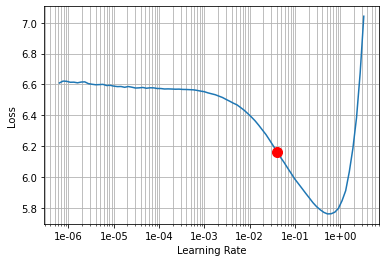

In [ ]:
tweet_model.recorder.plot(show_grid=True, suggestion=True)

As evident from the graph plotted above, we will take 3.98e-02  as the learning rate because, after that particular value, the loss becomes minimum.

We must set the cycle length to 1 as we train only with one epoch 'moms' refers to a tuple which has the parameters as (max_momentum,min_momentum).

In [ ]:
tweet_model.fit_one_cycle(cyc_len=1,max_lr=3.98e-02,moms=(0.85,0.75))

epoch,train_loss,valid_loss,accuracy,time
0,4.444878,3.936272,0.260296,00:11


We will now unfreeze the LSTM layers of the model

In [ ]:
tweet_model.unfreeze()

In [ ]:
tweet_model.fit_one_cycle(cyc_len=5, max_lr=slice(3.98e-02/(2.6**4),3.98e-02), moms=(0.85, 0.75))

epoch,train_loss,valid_loss,accuracy,time
0,3.781284,3.828749,0.274163,00:16
1,3.675354,3.750796,0.286217,00:16
2,3.303514,3.777685,0.291462,00:15
3,2.665107,3.960861,0.293471,00:14
4,2.027926,4.206308,0.286440,00:15


In [ ]:
tweet_model.save_encoder('encoder')

### Building Classification Model

In this section, we will change the model accordingly in order to perform the classification task.

We will again create 'TextClassDataBunch' from the dataset tweet_train.csv.
We will then pass vocab in order to ensure the vocab is the same which was modified in the fine-tuned Language Model.


In [ ]:
tweet_class = TextClasDataBunch.from_csv(path='',csv_name='tweet_train.csv',
                              vocab=tweet.train_ds.vocab,bs=32,text_cols='newtext',label_cols='airline_sentiment')


Let us see how the batch looks like

In [ ]:
tweet_class.show_batch()

text,target
xxbos @united xxmaj hi have a question re future xxmaj flight xxmaj booking xxmaj problems . xxup xxunk - xxup jac 29 / 9 xxup jac - xxup lax 8 / 10 xxup lax - xxup xxunk 13 / 10 . i 'm * xxup xxunk xxmaj what is checked bag allowance for xxup jac - xxup lax ?,neutral
xxbos @usairways xxup plans xxup changed ! xxup is xxup that xxup what u xxup call xxup not xxup bein xxup able 2 xxup park xxup on xxup time xxup planes w a 2 xxup hr xxup layover n b xxup able 2 xxup make xxup ur xxup connection ! seriously,negative
xxbos @americanair xxup poor xxup experience 2day at ord xxunk . 8 emp . w / 3 cust . 10 waiting . xxmaj asked to speak w / supervisor . xxmaj told 20 min . xxmaj in a mtg ! ! xxmaj what ? ! ? !,negative
xxbos @united xxup fail xxmaj you xxmaj cancelled xxmaj flightled our flight frm xxup xxunk and then used our reserv home to xxup iah ( from xxup sea ) for reflight xxmaj booking xxmaj problems w / out xxup our xxup permission ! ! xxup ph6rps,negative
"xxbos xxup by xxup the xxup grace xxup of xxup god , i xxup made xxup it ! “ @usairways : xxup xxunk _ _ xxmaj we do n't have those xxunk in here . xxmaj we hope you can make that flight . ”",positive


Now we will create a new learner object by using 'text_classifier_learner.' The primary concept behind this learner object is similar to 'language_model_learner' because we will use the same architecture of AWD_LSTM. Also, it can similarly take in callbacks that basically allow us to train our model with unique optimization techniques. 


In [ ]:
tweet_model = text_classifier_learner(tweet_class, AWD_LSTM, drop_mult=0.5)

Then we will load the encoder into this object i.e learner

In [ ]:
tweet_model.load_encoder('encoder')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (10540 items)
x: TextList
xxbos @southwestair xxmaj oh no worries xxup xxunk , no xxunk here . xxmaj better to have xxup no lounges than like xxmaj delta who has them but does disappoint !,xxbos @americanair because you wo n't get our bags for us because you said they would go on to xxmaj cincinnati even though we ca n't . xxmaj who exactly is,xxbos @southwestair xxmaj yes ! xxmaj just a few minutes after my tweet . xxmaj she was able to reschedule her flight . xxmaj thanks !,xxbos @united most terrible flight experience happening to everyone right now on xxmaj flight : xxup ua1750 6 delays 4 hrs total missed all my flights now thnx,xxbos @southwestair- ... was only less than xxunk , but it helped . xxmaj had xxunk incoming , but not fast enough to keep pts from xxunk .
y: CategoryList
positive,negative,positive,negative,neutral
Path: .;

Valid: LabelList (2636 items)
x: TextList
xxbos @united received hotel but no food . xxmaj also 

In [ ]:
tweet_model.model

SequentialRNN(
  (0): MultiBatchEncoder(
    (module): AWD_LSTM(
      (encoder): Embedding(5896, 400, padding_idx=1)
      (encoder_dp): EmbeddingDropout(
        (emb): Embedding(5896, 400, padding_idx=1)
      )
      (rnns): ModuleList(
        (0): WeightDropout(
          (module): LSTM(400, 1152, batch_first=True)
        )
        (1): WeightDropout(
          (module): LSTM(1152, 1152, batch_first=True)
        )
        (2): WeightDropout(
          (module): LSTM(1152, 400, batch_first=True)
        )
      )
      (input_dp): RNNDropout()
      (hidden_dps): ModuleList(
        (0): RNNDropout()
        (1): RNNDropout()
        (2): RNNDropout()
      )
    )
  )
  (1): PoolingLinearClassifier(
    (layers): Sequential(
      (0): BatchNorm1d(1200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Dropout(p=0.2, inplace=False)
      (2): Linear(in_features=1200, out_features=50, bias=True)
      (3): ReLU(inplace=True)
      (4): BatchNorm1d(50, ep

### Gradual Unfreezing

Gradual Unfreezing is the process to unfreeze the last layers as it contains the most general information. After fine-tuning unfrozen layers for one epoch, we go for the next lower layer and repeat until we complete all layers until convergence last iteration.

We will unfreeze and train layers of our model one by one from top to bottom, which means from the last layer to inner layers. This is done to prevent the model from forgetting the features.

In [ ]:
tweet_model.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 5.25E-03
Min loss divided by 10: 4.37E-02


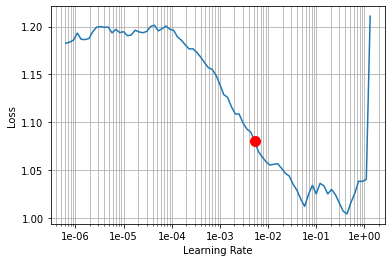

In [ ]:
tweet_model.recorder.plot(show_grid=True, suggestion=True)

Similarly, how we did before, we choose a learning rate (optimized one) before the graph starts descending and reaches a minimum. Along with it, we will use the one cycle policy.

In [ ]:
tweet_model.fit_one_cycle(5,5.25E-03,moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.605307,0.520583,0.784901,00:07
1,0.589400,0.542774,0.783005,00:07
2,0.585993,0.513476,0.788316,00:07
3,0.607882,0.517270,0.781866,00:08
4,0.604852,0.510279,0.788316,00:08


Now we will unfreeze the next layer.

In [ ]:
tweet_model.freeze_to(-2)

As different layers capture different types of information, they should be fine-tuned to varying extents. Instead of using the same learning rate for all layers of the model, discriminative fine-tuning helps us apply specific learning rates to different layers.

Thus, we will then train with the next unfrozen layer and apply discriminative fine-tuning.

In [ ]:
tweet_model.fit_one_cycle(5,slice(5.25E-03/(2.6**4),5.25E-03))

epoch,train_loss,valid_loss,accuracy,time
0,0.587133,0.495548,0.794385,00:09
1,0.551013,0.485977,0.812595,00:08
2,0.483074,0.490704,0.806904,00:09
3,0.412981,0.483046,0.811077,00:09
4,0.413093,0.477565,0.815630,00:09


Now we will repeat the process with next layer.

In [ ]:
tweet_model.freeze_to(-3)
tweet_model.fit_one_cycle(5,slice(5.25E-03/(2.6**4),5.25E-03))

epoch,train_loss,valid_loss,accuracy,time
0,0.428882,0.500166,0.801214,00:13
1,0.431213,0.472223,0.811457,00:15
2,0.324065,0.514988,0.813733,00:14
3,0.223403,0.584737,0.809939,00:14
4,0.162557,0.600649,0.807663,00:13


At this step we will unfreeze all the layers and repeate the process again.

In [ ]:
tweet_model.unfreeze()
tweet_model.fit_one_cycle(5,slice(5.25E-03/(2.6**4),5.25E-03))

epoch,train_loss,valid_loss,accuracy,time
0,0.155368,0.660584,0.809560,00:18
1,0.205057,0.634501,0.809181,00:20
2,0.174063,0.638511,0.817147,00:19
3,0.125841,0.704197,0.814492,00:17
4,0.078393,0.695188,0.811457,00:19


## Part 3 - Prediction and Evaluating Model

### Testing Set 

In [ ]:
test = pd.read_csv('tweet_test.csv')
print(test[['newtext','airline_sentiment']])
test.head()

                                                newtext airline_sentiment
0     @USAirways How can I change without penalty an...           neutral
1     @SouthwestAir I have been in contact and know ...           neutral
2     @united your b737-800w  literally the smallest...          negative
3     .@USAirways I rebooked myself - but Cancelled ...          negative
4     @americanair never fails to disappoint. waitin...          negative
...                                                 ...               ...
1459  @AmericanAir are you kidding me?  No one answe...          negative
1460  @united your airline is a joke. 1 person worki...          negative
1461  @JetBlue just wondering if the website is havi...          negative
1462  @SouthwestAir there really should not be guida...          negative
1463  @AmericanAir is the situation at JFK this even...          negative

[1464 rows x 2 columns]


,Unnamed: 0,newtext,airline_sentiment
0,11823,@USAirways How can I change without penalty an...,neutral
1,6481,@SouthwestAir I have been in contact and know ...,neutral
2,1679,@united your b737-800w literally the smallest...,negative
3,10969,.@USAirways I rebooked myself - but Cancelled ...,negative
4,14286,@americanair never fails to disappoint. waitin...,negative


### Predicting the Tweets

Now we will add a new column with the predicted values on 'test' which is the Test set 

In [ ]:
test['airline_senti_pred'] = test['newtext'].apply(lambda row:str(tweet_model.predict(row)[0]))

We will print the accuracy of each row against the corresponding test set

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

In [ ]:
print("Accuracy of Model: {}".format(accuracy_score(test['airline_sentiment'],test[
    'airline_senti_pred'])))

Accuracy of Model: 0.8258196721311475


### Plotting Confusion Matrix

Now we will plot the Confusion matrix for the Test set using the confusion_matrix class imported from sklearn.metrics.

In [ ]:
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(test['airline_sentiment'], test['airline_senti_pred'])
print(cf_matrix)

[[829  51  22]
 [100 212  24]
 [ 40  18 168]]


## Part 4 - Conclusion

After analyzing all the different learning rates and methods we used, the Accuracy that we got was 0.825
Language modeling can be viewed as the ideal source for NLP, as it encompasses many aspects of language, such as long-term interactions, hierarchical relationships, and sentiments. It provides data in almost unlimited quantities for most domains and languages.
As evident from the gradual unfreezing, upon increasing the count of the unfrozen layer per epoch, the validation loss was increasing, which could result in overfitting the model. The best case we obtained was with two layers unfrozen because, in that case, both the validation loss and the training loss was considerably less.

Future Improvements:
1. Since the data is a bit imbalanced (Skewed towards Negative tweets), Accuracy cannot be the best way to evaluate the model for the long run. We also need to use Precision, Recall, and F1 Score.
2. More exploration of Discriminative Fine-Tuning could be undoubtedly valuable to achieve more reliable and better results.
3. It's not immediately clear what the common thread that led to the mislabeling of specific tweets but possible causes includes missing signs from hashtags, non-grammatical sentences, or misspellings that commonly contribute to the classification error.
4. It could be beneficial to allocate more time to Feature Engineering and fit the Language Model to match the vocabulary and language style in tweets better.